In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
pd.options.mode.chained_assignment = None  # default='warn'


## Importation des csv

In [49]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

#df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

Dans le dataset des reviews on transforme la colonne review_comment_title et review_comment_message pour obtenir la longueur du message et du titre

In [51]:
from functions import *
df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.groupby(["order_id","review_score"]).agg({"length_comment_title":"max","length_comment_message":"max","review_answer_timestamp":"first"})

In [52]:
df_olist_order_reviews_dataset.reset_index(inplace=True)

In [53]:
# Convertir la colonne 'date' en un objet de type datetime
df_olist_order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews_dataset['review_answer_timestamp'])

# Groupby order_id et trouver l'index de la date la plus récente pour chaque order_id
latest_dates = df_olist_order_reviews_dataset.groupby('order_id').review_answer_timestamp.idxmax()

# Utilisez l'index trouvé pour sélectionner les lignes avec les dates les plus récentes
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.loc[latest_dates]


Dans le dataset des produits on remplace les nan de la colonne product_photos_qty par 0.

On remplace les nan de la colonne product_category_name par unknown.

On remplace les nan de la colonne product_description_lenght par 0.

On drop la colonne product_name_lenght.


In [56]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)

In [57]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

Dans le dataset des items on groupe par les colonnes order_id ,product_id et seller_id . Pour obtenir le nombre de ce produit achete dans cet commande pour ce vendeur

In [58]:
def get_mode(x):
    return x.mode().iloc[0]
    
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id"]).agg({"product_id":get_mode,"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=["product_most_frequent",'nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

Regroupement par order_id dans le dataset payments pour que les order_id soit unique

In [59]:
df_olist_order_payments_dataset = df_olist_order_payments_dataset.groupby(["order_id"]).agg({"payment_type":lambda x:",".join(set(x)),"payment_sequential":"count","payment_installments":"max","payment_value":"sum"})
df_olist_order_payments_dataset.reset_index(inplace=True)

In [60]:
df_olist_order_payments_dataset["payment_type"]= df_olist_order_payments_dataset["payment_type"].apply(lambda x:'credit_card,voucher' if x == "voucher,credit_card" else x)

## Merge des datasets

In [61]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")

In [62]:
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")

In [63]:
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")

In [64]:
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")

In [65]:
df_merge = df_merge.merge(df_product,how="left",right_on='product_id',left_on="product_most_frequent")

In [66]:
# df_merge = df_merge.merge(df_olist_sellers_dataset,how="outer",on="seller_id")

## Visualisation des valeurs manquantes

<AxesSubplot: >

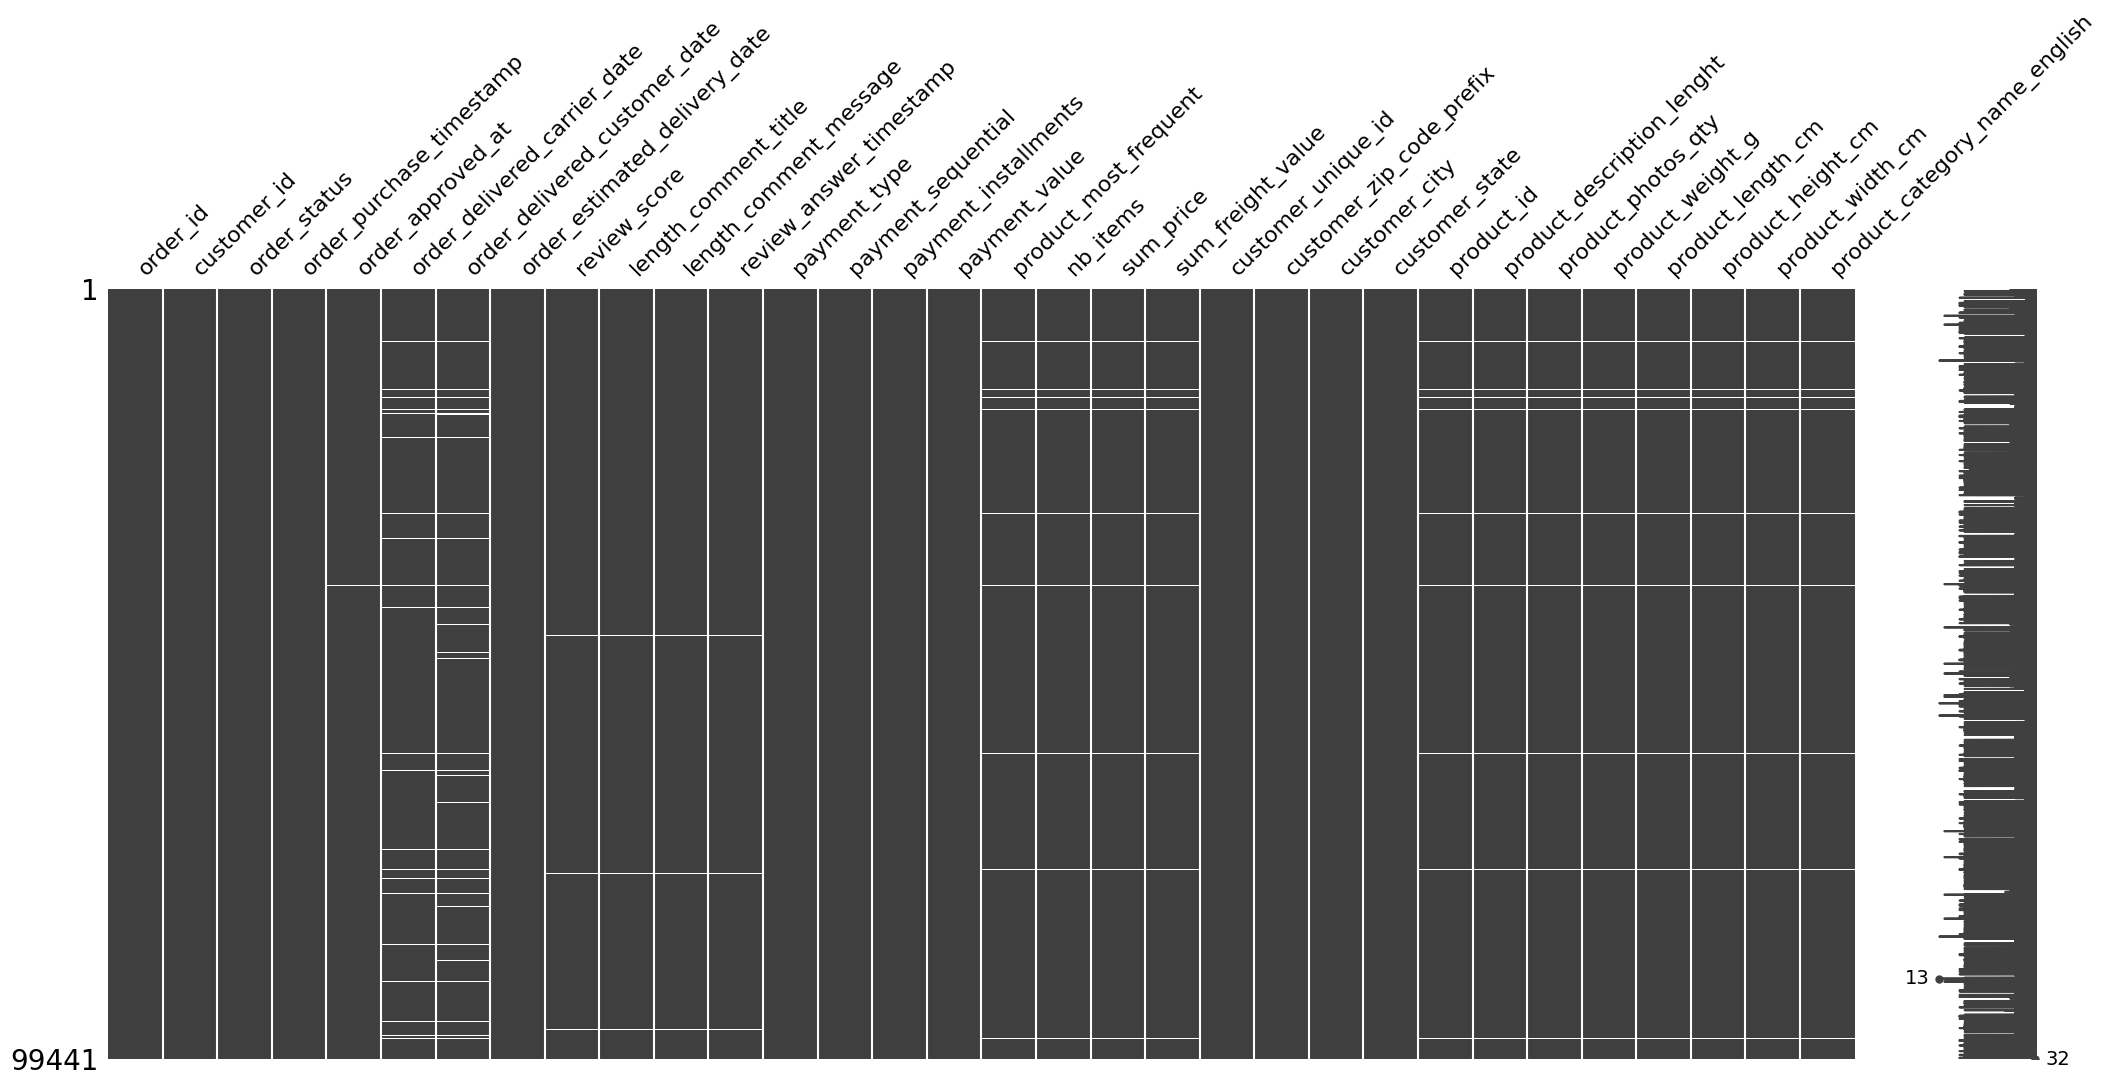

In [67]:
import missingno as msno

msno.matrix(df_merge)

realisation d'un rapport avec pandas profilling

In [68]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df_merge, title="Pandas Profiling Report")
# profile.to_file(output_file='rapport_avant.html')

Nous ne conserverons que les order_statuts qui sont "delivered" car les autres catégories sont trop peu représentées

In [69]:
df_merge = df_merge.loc[df_merge['order_status'] == "delivered"]

In [70]:
df_merge['order_purchase_timestamp'] = pd.to_datetime(df_merge['order_purchase_timestamp'])
df_merge = df_merge.loc[df_merge['order_purchase_timestamp'].dt.year !=2016]


In [71]:
df_merge['order_purchase_time']=df_merge['order_purchase_timestamp'].dt.strftime('%m/%d/%Y')

In [72]:
df_temp = df_merge.groupby("customer_unique_id").agg({"order_purchase_time":"max"})
df_temp.reset_index(inplace=True)

In [73]:
df_temp["order_purchase_time"] =pd.to_datetime(df_temp["order_purchase_time"])

In [74]:
def nombre_de_jour(date):
    delta = pd.to_datetime('22/10/2018',dayfirst=True) - date
    return delta

df_temp["recence"] = df_temp["order_purchase_time"].apply(lambda x: nombre_de_jour(x)) 
df_temp["recence"] = df_temp["recence"].astype('timedelta64[D]')

In [75]:
df_temp.drop("order_purchase_time",axis=1,inplace=True)

In [76]:
df_merge = df_merge.merge(df_temp,on="customer_unique_id",how="outer")

In [77]:
maison=dict.fromkeys(['housewares','home_appliances', 'la_cuisine', 'home_confort','home_comfort_2','home_appliances_2', 'office_furniture','home_construction', 'air_conditioning'],"maison")
outil = dict.fromkeys(['construction_tools_construction','construction_tools_lights','costruction_tools_tools','construction_tools_safety'],"outil")
jardinnage=dict.fromkeys(['flowers','costruction_tools_garden', 'garden_tools'],"jardinnage")
mobilier_electromenager=dict.fromkeys(['furniture_living_room','small_appliances_home_oven_and_coffee', 'small_appliances','furniture_mattress_and_upholstery', 'kitchen_dining_laundry_garden_furniture','furniture_bedroom','bed_bath_table','furniture_decor'],"mobilier_electromenager")
enfant=dict.fromkeys(['diapers_and_hygiene','baby','toys'],"enfant")
fashion=dict.fromkeys(['fashion_sport', 'fashion_childrens_clothes','fashion_underwear_beach','fashion_shoes','fashion_male_clothing', 'fashio_female_clothing','fashion_bags_accessories'],"fashion")
sport=dict.fromkeys(['sports_leisure'],"sport")
auto=dict.fromkeys(['auto','signaling_and_security'],"auto")
service=dict.fromkeys(['industry_commerce_and_business','agro_industry_and_commerce','security_and_services','market_place'],"service")
fete = dict.fromkeys(['party_supplies','christmas_supplies'],"fete")
papeterie=dict.fromkeys(["stationery"],"papeterie")
beaute=dict.fromkeys(['perfumery','health_beauty'],"beaute")
music=dict.fromkeys(['music','musical_instruments','cds_dvds_musicals'],"music")
animaux=dict.fromkeys(['pet_shop'],"animaux")
voyage=dict.fromkeys(['luggage_accessories'],"voyage")
informatique=dict.fromkeys([ 'computers','watches_gifts','audio','fixed_telephony','tablets_printing_image','electronics', 'computers_accessories', 'telephony'],"informatique")
loisir=dict.fromkeys(['consoles_games','dvds_blu_ray'],"loisir")
alimentation=dict.fromkeys(['food', 'drinks', 'food_drink'],"alimentation")
livre=dict.fromkeys(['books_technical','books_general_interest','books_imported'],"livre")
inconue=dict.fromkeys(["unknown"],"inconue")
autre=dict.fromkeys(['cool_stuff'],"autre")
art=dict.fromkeys(['art','arts_and_craftmanship','cine_photo'],"art")

dict_map={**maison,**outil,**jardinnage,**mobilier_electromenager,
        **enfant,**fashion,**sport,**auto,**service,**fete,
        **papeterie,**beaute,**music,**animaux,**voyage,**informatique,
        **loisir,**alimentation,**livre,**inconue,**autre,**art
}
df_merge["product_category_name_english"] = df_merge["product_category_name_english"].map(dict_map)


In [78]:
df_merge.drop(['order_id',"order_approved_at","order_delivered_carrier_date","order_delivered_customer_date", 'payment_sequential',"order_estimated_delivery_date", "product_most_frequent",'product_id',"review_answer_timestamp", 'customer_zip_code_prefix']
      ,axis=1,inplace=True
      )

In [79]:
df_merge["length_comment_title"].fillna(0,inplace=True)
df_merge["length_comment_message"].fillna(0,inplace=True)
df_merge["review_score"].fillna(-1,inplace=True)

In [80]:
df_merge["product_category_name_english"].fillna("indisponible",inplace=True)
df_merge.fillna(-1,inplace=True)

<AxesSubplot: >

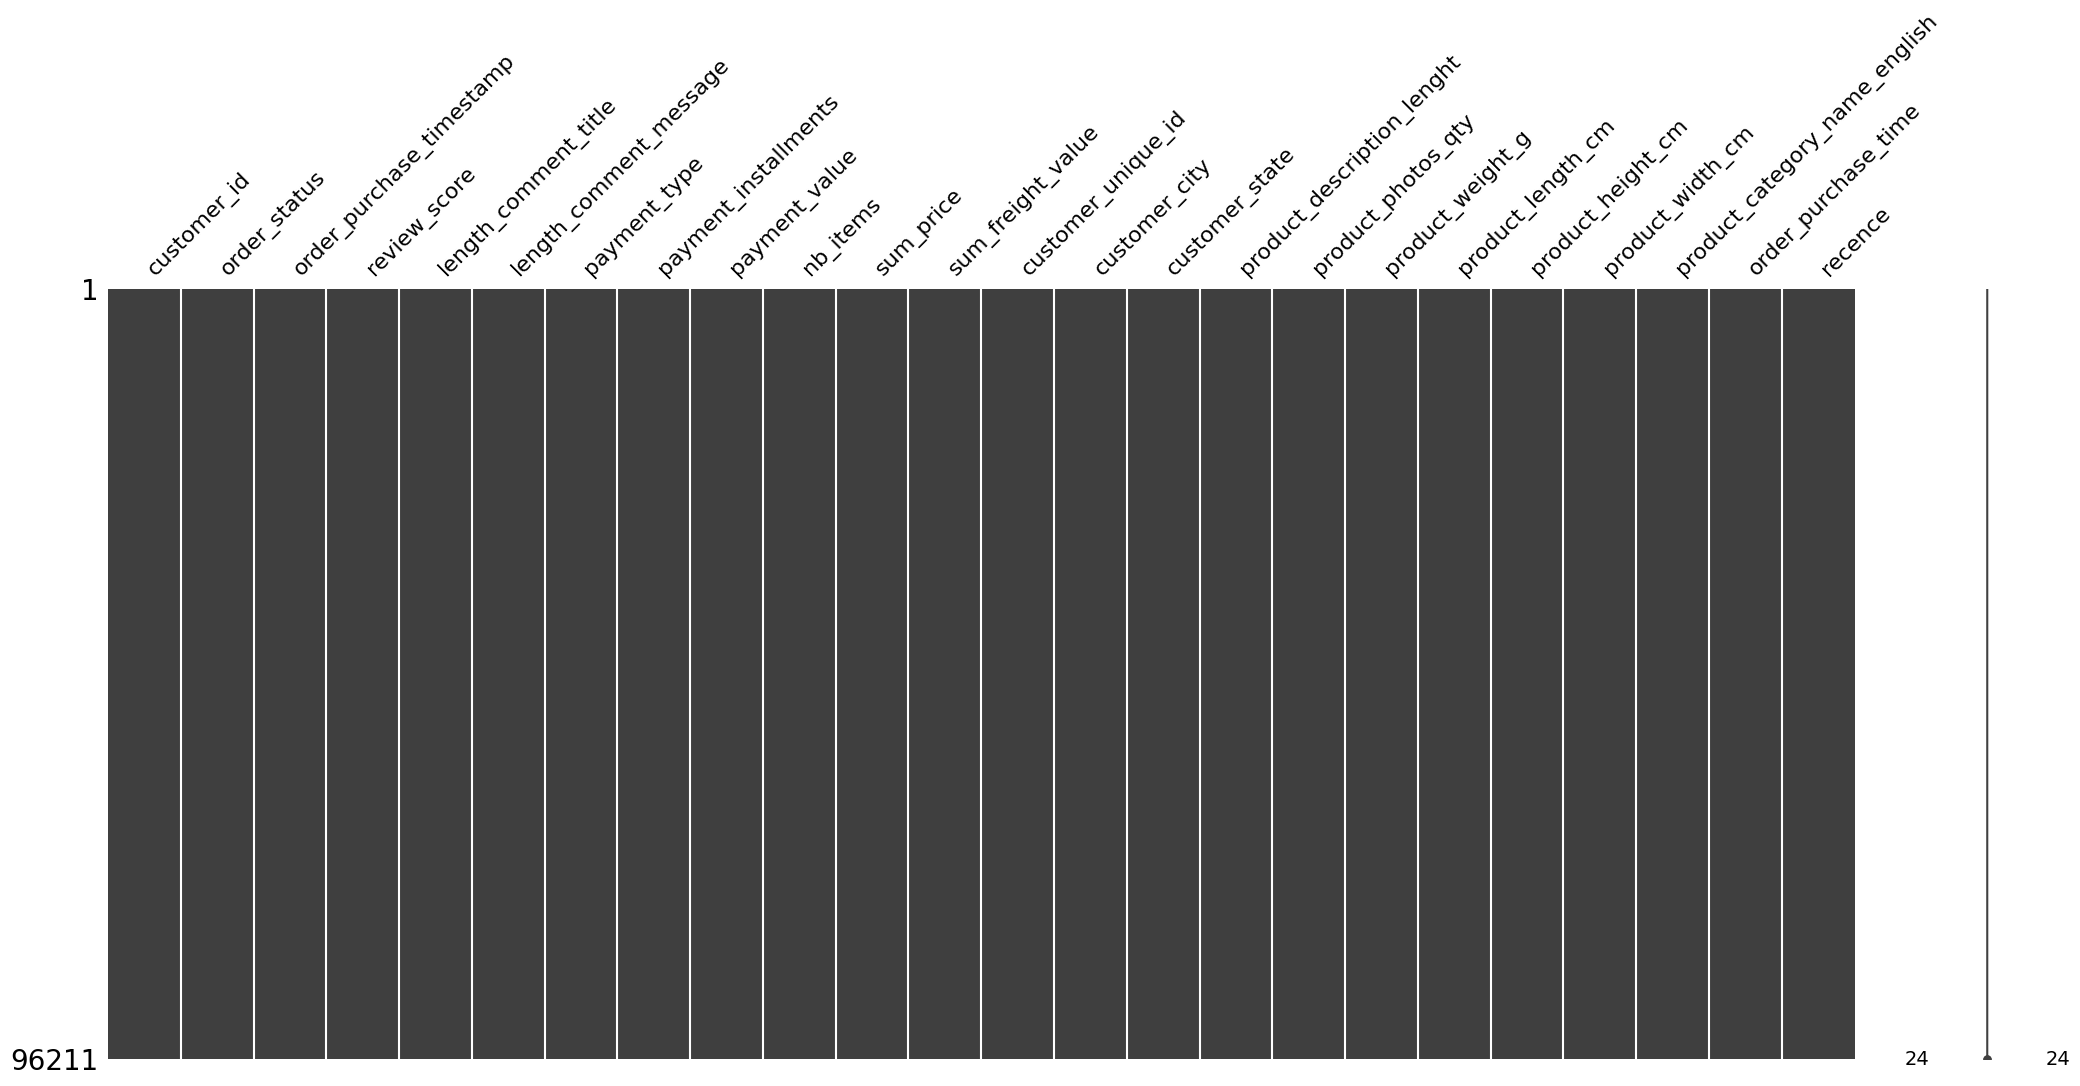

In [81]:
msno.matrix(df_merge)

In [82]:
df_merge.columns

Index(['customer_id', 'order_status', 'order_purchase_timestamp',
       'review_score', 'length_comment_title', 'length_comment_message',
       'payment_type', 'payment_installments', 'payment_value', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id', 'customer_city',
       'customer_state', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english',
       'order_purchase_time', 'recence'],
      dtype='object')

In [85]:
list_sum = ["nb_items","payment_value"]
list_count = ["customer_id"]
list_mod = ["payment_type","customer_state","customer_city","product_category_name_english"]
list_mean = ["review_score","length_comment_title","length_comment_message"]
list_first = ["recence"]
dict_sum = dict.fromkeys(list_sum,"sum")
dict__count = dict.fromkeys(list_count,"count")
dict_mod = dict.fromkeys(list_mod,get_mode)
dict_mean = dict.fromkeys(list_mean,"mean")
dict_first = dict.fromkeys(list_first,"first")
dict_agg = {**dict_sum ,**dict__count,**dict_mod,**dict_mean,**dict_first }


In [86]:
df_freq = df_merge.groupby("customer_unique_id").agg(dict_agg)

In [88]:
df_freq.columns = ["nb_items_total","montant_total","nb_commande","most_frequent_payment_type","customer_state","customer_city","most_frequent_product_category","mean_review_score","mean_length_comment_title","mean_length_comment_message","recence"]

In [89]:
df_freq

,nb_items_total,montant_total,nb_commande,most_frequent_payment_type,customer_state,customer_city,most_frequent_product_category,mean_review_score,mean_length_comment_title,mean_length_comment_message,recence
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,141.90,1,credit_card,SP,cajamar,mobilier_electromenager,5.0,15.0,111.0,165.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,27.19,1,credit_card,SP,osasco,beaute,4.0,0.0,0.0,168.0
0000f46a3911fa3c0805444483337064,1.0,86.22,1,credit_card,SC,sao jose,papeterie,3.0,0.0,0.0,591.0
0000f6ccb0745a6a4b88665a16c9f078,1.0,43.62,1,credit_card,PA,belem,informatique,4.0,0.0,12.0,375.0
0004aac84e0df4da2b147fca70cf8255,1.0,196.89,1,credit_card,SP,sorocaba,informatique,5.0,0.0,0.0,342.0
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2.0,2067.42,1,credit_card,PE,sanharo,beaute,5.0,0.0,0.0,501.0
fffea47cd6d3cc0a88bd621562a9d061,1.0,84.58,1,credit_card,BA,feira de santana,enfant,4.0,0.0,0.0,316.0
ffff371b4d645b6ecea244b27531430a,1.0,112.46,1,credit_card,MT,sinop,auto,5.0,0.0,0.0,622.0


In [90]:
df_freq.reset_index(inplace=True)

In [91]:
df_freq.drop(["customer_unique_id","customer_city"],axis=1,inplace=True)

In [92]:
df_freq

,nb_items_total,montant_total,nb_commande,most_frequent_payment_type,customer_state,most_frequent_product_category,mean_review_score,mean_length_comment_title,mean_length_comment_message,recence
0,1.0,141.90,1,credit_card,SP,mobilier_electromenager,5.0,15.0,111.0,165.0
1,1.0,27.19,1,credit_card,SP,beaute,4.0,0.0,0.0,168.0
2,1.0,86.22,1,credit_card,SC,papeterie,3.0,0.0,0.0,591.0
3,1.0,43.62,1,credit_card,PA,informatique,4.0,0.0,12.0,375.0
4,1.0,196.89,1,credit_card,SP,informatique,5.0,0.0,0.0,342.0
...,...,...,...,...,...,...,...,...,...,...
93099,2.0,2067.42,1,credit_card,PE,beaute,5.0,0.0,0.0,501.0
93100,1.0,84.58,1,credit_card,BA,enfant,4.0,0.0,0.0,316.0
93101,1.0,112.46,1,credit_card,MT,auto,5.0,0.0,0.0,622.0
93102,1.0,133.69,1,credit_card,ES,informatique,5.0,8.0,133.0,173.0


In [93]:
df_freq.to_csv("data/data_merge.csv",index=False)